In [151]:
from data_parsing import Parser

subject = 1
run = [3, 7, 11]

parser = Parser(subject=subject, runs=run, mne_path="./mne_data")
parser.load_data()

Loading data for subject 1, at runs [3, 7, 11]



In [152]:
MONTAGE = 'standard_1005'
noisy_channels = ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6',
                    'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']
WALL_ELEC_FREQUENCY = 60
MOTOR_FREQ_RANGE = (8.0, 40.0)
montage = parser.select_montage(MONTAGE)
parser.reduce_noise(WALL_ELEC_FREQUENCY, noisy_channels)
picks = parser.reduce_noise()
parser.focus_and_clean(significant_frequencies=MOTOR_FREQ_RANGE)

Selecting montage: standard_1005

Reducing noise:
Removing frequency 60
Removing bad or noisy channels: ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']

Reducing noise:
Removing bad or noisy channels: bads

Focussing on significant frequencies



In [153]:
import json
parser.get_events()
print(json.dumps(parser.event_id, indent = 4))
print(f"{parser.events.shape = }, {parser.events.dtype = }")

Getting events from annotations

{
    "T0": 1,
    "T1": 2,
    "T2": 3
}
parser.events.shape = (90, 3), parser.events.dtype = dtype('int64')


In [154]:
from mne import Epochs

tmin, tmax = 0., 5.
epochs = Epochs(parser.raw, parser.events, parser.event_id, tmin, tmax, proj=True, baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1]
epoch_data = epochs.get_data()
print(f"{epoch_data.shape = }")
# print(f"{epochs.events.shape = }")
# print(f"Num channels: {len(parser.raw.info['ch_names'])}")
# epoch_data[0, :, 0]
# epochs
events = epoch_data.shape[0]
num_electrodes = epoch_data.shape[1]
n_measures = epoch_data.shape[2]
print(f"{events = } {num_electrodes = } {n_measures = }")

# events * n_measures / (tmax - tmin) / 1000

epoch_data.shape = (87, 42, 801)
events = 87 num_electrodes = 42 n_measures = 801


Classification accuracy: 0.600000 / Chance level: 0.517241


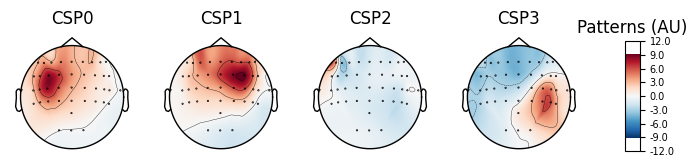

In [155]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne.decoding import CSP
import numpy as np

# Define a monte-carlo cross-validation generator (reduce variance):
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

lol = csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)')

In [159]:
# clf.fit(X = )
# clf.predict()
# i = 0
# csp.transform(npepochs_data[i], labels[i])
# csped_epoch = csp.transform(epochs_data[i])
# epochs_data.shape
# epochs_data[i].shape
for i in range(10):
    print(clf.predict(np.array([epochs_data[i]])), labels[i])

[1] 1
[0] 0
[1] 0
[1] 1
[0] 0
[1] 1
[1] 1
[1] 0
[1] 0
[1] 1


Automatically created module for IPython interactive environment
Classification accuracy: 0.933333 / Chance level: 0.533333
[[ 8.25339972 -2.37450664  6.18898404 -5.5601886 ]]
[[ 8.5212808   5.12035193  0.49015726 -4.61829394]]
[[ 5.96518203  1.84995064  6.42872934 -5.5822826 ]]
[[ 0.24931479  9.90604122 -3.28469     6.03591267]]
[[ 0.01679819  7.52810795  5.38771797 -3.26930787]]
[[10.2187357  -1.97458858  6.55979759 -5.44069952]]
[[ 7.06715957 -0.30960248  7.80056298 -4.78758955]]
[[ 8.81137491  1.03668426  6.28995222 -4.49044011]]
[[  9.96118997   8.65474987  -1.29813306 -13.55614533]]
[[ 9.98076448  0.44695098  7.45102998 -4.00076758]]


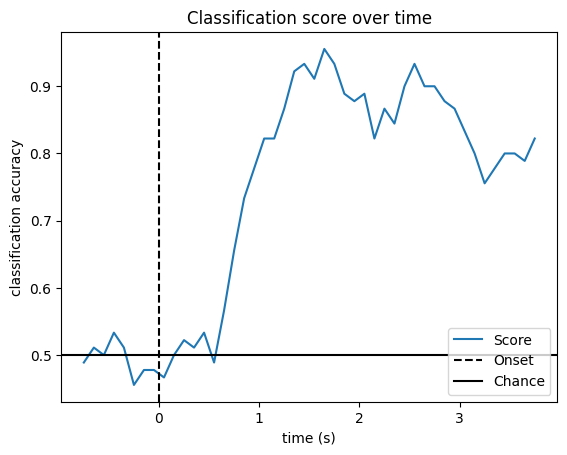

In [164]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2




# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

# csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)




sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_indexes, test_indexes in cv_split:
    y_train, y_test = labels[train_indexes], labels[test_indexes]
    # print(f"{y_train.shape = }, \n{y_test.shape = } \n{epochs_data_train[train_indexes].shape = } \n{epochs_data_train.shape  = }")
    # print(list(set(train_indexes + test_indexes)))
    # print()
    X_train = csp.fit_transform(epochs_data_train[train_indexes], y_train)
    X_test = csp.transform(epochs_data_train[test_indexes])

    # fit classifier
    lda.fit(X_train, y_train)
    print(lda.coef_)


    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_indexes][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

In [140]:
print(lda.coef_)

# clf.__dict__
clf.steps[1][1].coef_

clf.predict()

[[ 9.98076448  0.44695098  7.45102998 -4.00076758]]


TypeError: predict() missing 1 required positional argument: 'X'

In [147]:
lol = np.array([10, 11, 12, 13, 14])
lol[[1,2,4]]


array([11, 12, 14])